In [109]:
import os
import numpy as np
import pandas as pd
import random
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
from scipy import signal
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, Flatten, Activation, Lambda, Convolution1D, Dense
import obspy
from obspy.clients.fdsn import Client
%load_ext autoreload
%autoreload 2
%matplotlib inline

# OS Parameters
model_folder = 'models/'
log_folder = 'logs/'
data_folder = 'data/'
tsne = TSNE()

c = Client('IRIS')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


REGIONAL NETWORK PROCESSING FOR AD-HOC SEISMIC ARRAYS:

Seismic event identification is a core verification regime for modern nuclear treaty monitoring. Traditionally, nuclear event identification has relied on a finely-tuned but sparsely-deployed global sensor grid, providing exquisite analysis of global seismicity at relatively low thresholds. New advances in global sensor deployment and big data processing can enable even lower thresholds, but this requires new algorithmic techniques and capabilities. This project focuses on integrating two state-of-the-art deep neural network algorithms for seismic signal detection and seismic event association to facilitate the processing of regional seismic networks at AFTAC. Because the project is focused on integration of two relatively high TRL research vectors, it is of great operational importance to AFTAC and has high visibility within the Center and broader treaty monitoring community. The project is currently operating on an accelerated development timeline that anticipates delivery of a minimum viable product at the end of July. This coincides nicely with the internship period and also affords the opportunity for collaboration with a large internal team at AFTAC along with another PhD candidate intern from the Florida Institute of Technology.

In [114]:
xt = [-113, -99, 39, 51]

cat = pd.read_pickle("USArray_07-13.pkl")

cat = cat.loc[(cat.LAT_1>xt[2]) & (cat.LAT_1<xt[3]) & (cat.LON_1>xt[0]) & (cat.LON_1<xt[1]) & 
              (cat.LAT>xt[2]) & (cat.LAT<xt[3]) & (cat.LON>xt[0]) & (cat.LON<xt[1])]

cat_trn = cat.loc[(cat.TIME > '2008') & (cat.TIME < '2009-03')]
cat_tst = cat.loc[(cat.TIME > '2009-03') & (cat.TIME < '2010')]

trn_sta = set(cat_trn.STA.value_counts()[cat_trn.STA.value_counts() > 50].index)
tst_sta = set(cat_tst.STA.value_counts()[cat_tst.STA.value_counts() > 50].index)
wav_sta = random.choices(list(trn_sta & tst_sta), k=5)

# this line of code makes the notebook determinisitc... comment out to use random stations
wav_sta = ['I19A', 'J20A', 'I19A', 'G21A', 'F18A']

ref_sta = 'J23A'

cat_trn = cat_trn.loc[(cat_trn.STA.isin(wav_sta + [ref_sta]))]
cat_tst = cat_tst.loc[(cat_tst.STA.isin(wav_sta + [ref_sta]))]

ref_sta = 'J23A'
wav_sta

['I19A', 'J20A', 'I19A', 'G21A', 'F18A']

In [115]:

def plot_cat_map(df, img_name='', explosions=False, novel_sta=False, ax=None, extents=None):
    ax1 = ax or plt.gca(projection=ccrs.PlateCarree())
    ax1.cla()
    # Set map extents.
    if extents is None:
        llcrnrlon = np.min(np.append(df.LON_1, df.LON)) - 1
        llcrnrlat = np.min(np.append(df.LAT_1, df.LAT)) - 2
        urcrnrlon = np.max(np.append(df.LON_1, df.LON)) + 2
        urcrnrlat = np.max(np.append(df.LAT_1, df.LAT))
        extents = [llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat]
        print(extents)
    ax1.set_extent(extents, ccrs.PlateCarree())

    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax1.add_image(cimgt.Stamen('terrain-background'), 6)
    ax1.add_feature(states_provinces, edgecolor='gray')
    ax1.coastlines('110m')
    ax1.add_feature(cfeature.LAND)
    ax1.add_feature(cfeature.COASTLINE)
    ax1.add_feature(cfeature.RIVERS)
    ax1.add_feature(cfeature.LAKES)

    df_events = df.drop_duplicates(subset=['EVENTID'], keep='first', inplace=False)
    if not explosions:
        # Plot events.
        lons = df_events.LON_1.values
        lats = df_events.LAT_1.values
        ax1.plot(lons, lats, '.', markersize=3, alpha=1, color='#ff6666', label='events', markerfacecolor='none')

    else:
        # Plot earthquakes.
        df_eq = df_events.loc[df_events.DEPTH != 0]
        lons = df_eq.LON_1.values
        lats = df_eq.LAT_1.values
        ax1.plot(lons, lats, '.', markersize=1.5, alpha=1, color='#ff6666', label='earthquakes', markerfacecolor='none')

        # Plot explosions.
        df_ex = df_events.loc[df_events.DEPTH == 0]
        lons = df_ex.LON_1.values
        lats = df_ex.LAT_1.values
        ax1.plot(lons, lats, '.', markersize=3, alpha=1, color='blue', label='explosions', markerfacecolor='none')

        # Plot stations.
    df_sta = df.sort_values('TIME').drop_duplicates(subset=['STA'], keep='first', inplace=False)
    if not novel_sta:
        lons = df_sta.LON.values
        lats = df_sta.LAT.values
        ax1.plot(lons, lats, 'x', markersize=7, alpha=1, color='black', label='stations', markerfacecolor='none')
        novel_events = None
    else:
        # Plot old stations.
        df_old = df_sta.loc[df_sta.novel_sta == 0]
        lons = df_old.LON.values
        lats = df_old.LAT.values
        ax1.plot(lons, lats, 'x', markersize=7, alpha=1, color='black', label='stations', markerfacecolor='none')

        # Plot new stations.
        df_new = df_sta.loc[df_sta.novel_sta == 1]
        lons = df_new.LON.values
        lats = df_new.LAT.values
        ax1.plot(lons, lats, 'o', markersize=7, alpha=1, color='#006475', label='novel stations', markerfacecolor='none')

        # Plot new region.
        lons = [-107.2, -107.2, -105.8, -105.8]
        lats = [45, 46.2, 46.2, 45]
        ax1.add_geometries([LinearRing(list(zip(lons, lats)))], ccrs.PlateCarree(), facecolor='#5ee8ff', edgecolor='#006475',
                           linewidth=2)
        novel_events = matplotlib.patches.Patch(edgecolor='#006475', facecolor='#5ee8ff', label='novel location', linewidth=2)

    handles, labels = ax1.get_legend_handles_labels()
    if novel_sta:
        handles.append(novel_events)

    ax1.legend(handles=handles, fontsize=10, loc='lower right')

    ax1.set_title(img_name)

[-113.8097, -99.8683, 39.7062, 50.8323]
[-113.5838, -102.2255, 38.6571, 46.2034]


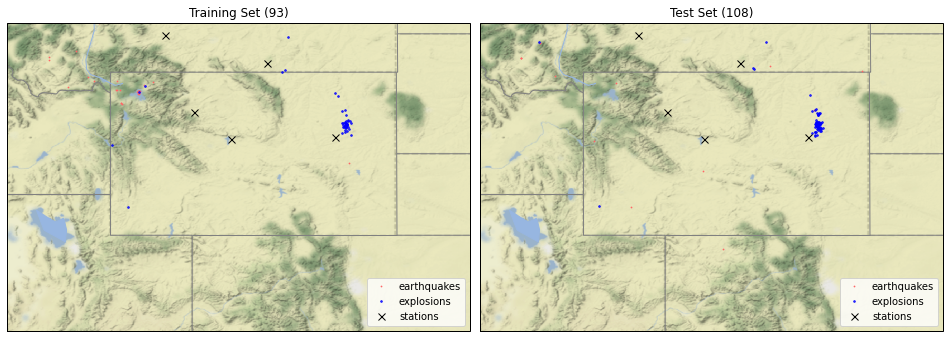

In [116]:
fig, ax = plt.subplots(ncols=2, figsize=(13,10), 
                       subplot_kw={'projection': ccrs.PlateCarree()}, sharex=True, sharey=True)

xt = [-109, -103, 42, 48]
plot_cat_map(cat_trn, f'Training Set ({len(cat_trn.EVENTID.unique())})', True, ax=ax[0])
plot_cat_map(cat_tst, f'Test Set ({len(cat_tst.EVENTID.unique())})', True, ax=ax[1])

fig.canvas.draw()
fig.tight_layout(pad=0, w_pad=1, h_pad=0)

#### Magnitude and Distance Histograms:
We also have included histograms of seismogram station-to-event distances as well as event magnitudes for both the test and training sets, shown in the figures below:

In [117]:
xt = [-105.5, -105, 43.3, 43.85]
cat_trn = cat_trn.loc[(cat_trn.STA == 'J23A') & (cat.LAT_1>xt[2]) & (cat.LAT_1<xt[3]) & (cat.LON_1>xt[0]) & (cat.LON_1<xt[1])]
display(cat_trn)

xt = [-105.5, -105, 43.3, 43.85]
cat_tst = cat_tst.loc[(cat_tst.STA == 'J23A') & (cat.LAT_1>xt[2]) & (cat.LAT_1<xt[3]) & (cat.LON_1>xt[0]) & (cat.LON_1<xt[1])]
display(cat_tst)

EVENTID  REPORTER   STA      LAT       LON    ELEV  CHN  DIST    BAZ  \
99246   12072029       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.39  208.2   
102668  12075445       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.41  209.5   
103742  12076394       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.33  216.5   
105519  12079682       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.27  232.9   
105868  12079842       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.40  211.1   
106983  12080669       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.23  233.9   
107038  12080678       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.35  216.2   
107437  12080966       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.34  215.0   
107561  12081068       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.38  216.2   
107588  12081140       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.38  214.4   
107812  12081213       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.45  207.1   
107883  12081277       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.32  231.7   
108869  12081574       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.39  203.5   
109157  12081806       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.38  211.8   
109685  12081997       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.17  233.9   
109786  12082007       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.34  206.1   
110174  12082156       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.35  215.7   
110237  12082250       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.30  215.4   
110490  12082413       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.35  223.4   
110738  12082686       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.32  217.1   
111472  12699498       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.38  200.5   
111705  12699934       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.30  261.0   
112040  12701054       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.40  214.6   
112648  12701456       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.40  209.0   
113018  12701463       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.31  220.1   
113249  12702055       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.33  219.4   

       ISCPHASE  ... AUTHOR      DATE_1       TIME_1    LAT_1     LON_1  \
99246        Pg  ...    ISC  2008-11-02  20:59:43.13  43.7459 -105.3010   
102668       Pg  ...    ISC  2008-12-01  20:06:52.17  43.7608 -105.2757   
103742       Pg  ...    ISC  2008-12-08  19:07:27.67  43.6720 -105.2803   
105519       Pg  ...    ISC  2008-12-31  18:01:44.42  43.5683 -105.2542   
105868       Pg  ...    ISC  2009-01-02  19:00:47.23  43.7449 -105.2699   
106983       Pg  ...    ISC  2009-01-07  20:01:36.84  43.5393 -105.2981   
107038       Pg  ...    ISC  2009-01-07  21:08:19.77  43.6833 -105.2716   
107437       Pg  ...    ISC  2009-01-10  17:02:36.73  43.6810 -105.2866   
107561       Pg  ...    ISC  2009-01-11  22:06:31.39  43.7119 -105.2432   
107588       Pg  ...    ISC  2009-01-12  21:09:47.50  43.7172 -105.2587   
107812       Pg  ...    ISC  2009-01-13  20:11:09.66  43.8008 -105.2734   
107883       Pg  ...    ISC  2009-01-14  17:00:00.42  43.6011 -105.2101   
108869       Pg  ...    ISC  2009-01-17  21:20:08.42  43.7648 -105.3375   
109157       Pb  ...    ISC  2009-01-19  22:17:41.41  43.7257 -105.2785   
109685       Pg  ...    ISC  2009-01-21  18:33:04.61  43.5053 -105.3615   
109786       Pb  ...    ISC  2009-01-21  21:17:53.42  43.7111 -105.3463   
110174       Pg  ...    ISC  2009-01-23  19:14:57.62  43.6855 -105.2746   
110237       Pg  ...    ISC  2009-01-24  21:03:50.02  43.6511 -105.3116   
110490       Pg  ...    ISC  2009-01-26  21:07:33.73  43.6563 -105.2251   
110738       Pg  ...    ISC  2009-01-29  19:05:44.39  43.6596 -105.2872   
111472       Pg  ...    ISC  2009-02-03  22:06:16.30  43.7627 -105.3679   
111705       Pg  ...    ISC  2009-02-10  20:19:09.92  43.4507 -105.1514   
112040       Pg  ...    ISC  2009-02-17  21:03:59.11  43.7351 -105.2390   
112648       Pg  ... 

EVENTID  REPORTER   STA      LAT       LON    ELEV  CHN  DIST    BAZ  \
113734  12702215       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.35  231.1   
113777  12702309       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.29  207.9   
113881  12702381       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.20  227.2   
114020  12702441       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.29  222.9   
114082  12702454       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.31  220.9   
...          ...       ...   ...      ...       ...     ...  ...   ...    ...   
176126  16110194       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.39  212.9   
176648  16110298       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.14  213.1   
176730  16110341       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.39  206.3   
177878  16110680       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.30  223.6   
177931  16110733       NaN  J23A  43.4036 -105.5524  1499.0  BHZ  0.45  214.9   

       ISCPHASE  ... AUTHOR      DATE_1       TIME_1    LAT_1     LON_1  \
113734       Pg  ...    ISC  2009-03-01  21:01:38.85  43.6272 -105.1741   
113777       Pb  ...    ISC  2009-03-03  00:13:03.45  43.6589 -105.3671   
113881       Pg  ...    ISC  2009-03-03  20:04:21.69  43.5368 -105.3552   
114020       Pb  ...    ISC  2009-03-04  17:53:39.53  43.6150 -105.2832   
114082       Pb  ...    ISC  2009-03-04  21:04:57.87  43.6360 -105.2771   
...         ...  ...    ...         ...          ...      ...       ...   
176126       Pb  ...    ISC  2009-12-16  19:07:37.57  43.7333 -105.2600   
176648       Pg  ...    ISC  2009-12-18  19:50:02.24  43.5201 -105.4481   
176730       Pg  ...    ISC  2009-12-19  19:04:32.68  43.7492 -105.3183   
177878       Pg  ...    ISC  2009-12-26  16:50:00.19  43.6234 -105.2653   
177931       Pg  ...    ISC  2009-12-27  19:09:00.99  43.7704 -105.2025   

        DEPTH  AUTHOR_1 TYPE  MAG  Y  
113734    0.0       ISC   mb  3.6  1  
113777    0.0       IDC   ML  3.4  1  
113881    0.0       NaN  NaN  NaN  1  
114020    0.0       IDC   mb  3.4  1  
114082    0.0       ISC   mb  3.5  1  
...       ...       ...  ...  ... ..  
176126    0.0       IDC   ML  3.3  1  
176648    0.0       NaN  NaN  NaN  1  
176730    0.0       IDC   mb  3.6  1  
177878    0.0       IDC   ML  3.2  1  
177931    0.0       NaN  NaN  NaN  1  

[74 rows x 27 columns]

In [118]:
def get_wav(sta, st_time, en_time, c, fs=40):
    
    X = []
    stream = c.get_waveforms(network="*", location="", station=sta, channel="BHZ",
                             starttime=obspy.UTCDateTime(st_time), endtime=obspy.UTCDateTime(en_time))

    X = stream[0].data
    if X.shape >= (int((en_time - st_time).total_seconds() * fs),):
        return X
    else:
        raise Exception()


### Explore Training-Set Positives:

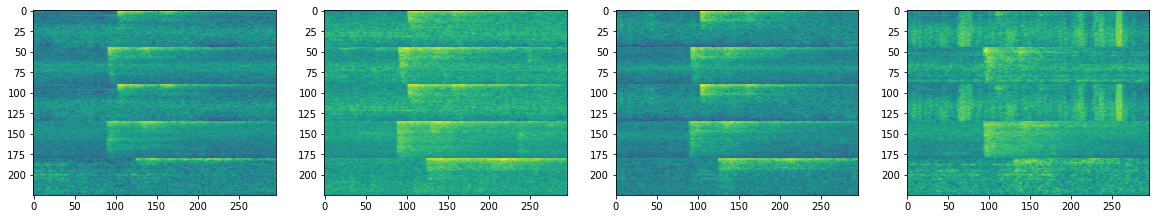

In [119]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
i=0
while i < 4:
    try:
        time = cat_trn.loc[cat_trn.STA == ref_sta].sample().iloc[0].TIME
        st_time = time - pd.Timedelta(35, 's')
        en_time = time + pd.Timedelta(175, 's')


        X = []
        for sta in wav_sta:
            s = get_wav(sta, st_time, en_time, c)
            fs = 40
            x = np.log(np.abs(signal.spectrogram(s, fs, nperseg=128, noverlap=100)[2]))[10:-10]
            x = (x -np.mean(x)) / np.std(x)
            X.append(x)
        X = np.vstack(X)

        ax[i].imshow(X)
        i += 1

    except:
        print('fail', sta)
    

            

In [120]:
def get_multispec_from_cat(cat, my_sta, fs=40):

    X = []
    for idx, event in cat.reset_index(drop=True).iterrows():

        st_time = event.TIME - pd.Timedelta(30, 's')
        en_time = event.TIME + pd.Timedelta(200, 's')

        x = []
        print(idx)
        try:
            for sta in my_sta:
                s = get_wav(sta, st_time, en_time, c)

                s = np.log(np.abs(signal.spectrogram(s, fs, nperseg=128, noverlap=100)[2]))[10:-10]
                s = (s -np.mean(s)) / np.std(s)
                x.append(s)
            x = np.vstack(x)

            if x.shape == (225, 325):
                X.append(x)
            
        except:
            print('fail')
            
    return np.stack(X)  

### Build Training Dataset:

In [121]:
if os.path.exists('X_trn_pos.npy'):
    X_trn_pos = np.load('X_trn_pos.npy')
else:
    X_trn_pos = get_multispec_from_cat(cat_trn, wav_sta)
    np.save('X_trn_pos.npy', X_trn_pos)

if os.path.exists('X_trn_neg.npy'):
    X_trn_neg = np.load('X_trn_neg.npy')
else:
    cat_trn_neg = cat_trn.copy()
    cat_trn_neg.TIME = cat_trn_neg.TIME + pd.Timedelta(40, 'h')
    X_trn_neg = get_multispec_from_cat(cat_trn_neg, wav_sta)
    np.save('X_trn_neg.npy', X_trn_neg)

X_trn_pos = np.repeat(np.expand_dims(X_trn_pos, 3), 3, 3)
X_trn_neg = np.repeat(np.expand_dims(X_trn_neg, 3), 3, 3)

X_trn = np.concatenate([X_trn_pos, X_trn_neg])
Y_trn = np.concatenate([np.ones(len(X_trn_pos)), np.zeros(len(X_trn_neg))])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


### Build Test Dataset:

In [122]:
if os.path.exists('X_tst_pos.npy'):
    X_tst_pos = np.load('X_tst_pos.npy')
else:
    X_tst_pos = get_multispec_from_cat(cat_tst, wav_sta)
    np.save('X_tst_pos.npy', X_tst_pos)
    



if os.path.exists('X_tst_neg.npy'):
    X_tst_neg = np.load('X_tst_neg.npy')
else:
    cat_tst_neg = cat_tst.copy()
    cat_tst_neg.TIME = cat_tst_neg.TIME + pd.Timedelta(40, 'h')
    X_tst_neg = get_multispec_from_cat(cat_tst_neg, wav_sta)
    np.save('X_tst_neg.npy', X_tst_neg)
    
X_tst_pos = np.repeat(np.expand_dims(X_tst_pos, 3), 3, 3)
X_tst_neg = np.repeat(np.expand_dims(X_tst_neg, 3), 3, 3)

X_tst = np.concatenate([X_tst_pos, X_tst_neg])
Y_tst = np.concatenate([np.ones(len(X_tst_pos)), np.zeros(len(X_tst_neg))])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
fail
59
fail
60
fail
61
fail
62
fail
63
fail
64
fail
65
fail
66
fail
67
fail
68
fail
69
fail
70
fail
71
fail
72
fail
73
fail
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
fail
59
fail
60
fail
61
fail
62
fail
63
fail
64
fail
65
fail
66
fail
67
fail
68
fail
69
fail
70
fail
71
fail
72
fail
73
fail


In [128]:
img_height = 225
img_width = 325

input_tensor = Input(shape=(img_height,img_width,3))

base_model = xception.Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')

x = base_model(input_tensor)
x = Dense(32, activation='relu')(x)
x = Dense(8, activation='relu')(x)

output_tensor = Dense(1, activation='sigmoid', name='output')(x)

model = Model(input_tensor, output_tensor, name='model')

model.compile(optimizer=Adam(lr=.001, clipnorm=1.),
              loss='binary_crossentropy',
              metrics=['accuracy'])


X_trn = np.concatenate([X_trn[:10], X_trn[-10:]])
Y_trn = np.concatenate([Y_trn[:10], Y_trn[-10:]])

In [129]:
model.fit(X_trn, Y_trn, batch_size=10, epochs=10, validation_data=(X_tst, Y_tst))

Train on 20 samples, validate on 116 samples
Epoch 1/10
20/20 [==============================] - 5s 269ms/sample - loss: 0.5887 - accuracy: 0.7000 - val_loss: 0.6201 - val_accuracy: 0.8879
Epoch 2/10
20/20 [==============================] - 1s 44ms/sample - loss: 0.3447 - accuracy: 1.0000 - val_loss: 0.2675 - val_accuracy: 0.9655
Epoch 3/10
20/20 [==============================] - 1s 45ms/sample - loss: 0.1912 - accuracy: 0.9500 - val_loss: 0.1494 - val_accuracy: 0.9741
Epoch 4/10
20/20 [==============================] - 1s 45ms/sample - loss: 0.1420 - accuracy: 1.0000 - val_loss: 0.0460 - val_accuracy: 0.9914
Epoch 5/10
20/20 [==============================] - 1s 45ms/sample - loss: 0.4456 - accuracy: 0.8000 - val_loss: 0.2094 - val_accuracy: 0.9397
Epoch 6/10
20/20 [==============================] - 1s 45ms/sample - loss: 0.2076 - accuracy: 0.9000 - val_loss: 0.4366 - val_accuracy: 0.9052
Epoch 7/10
20/20 [==============================] - 1s 45ms/sample - loss: 0.0960 - accuracy: 0.

In [130]:
Y_hat = model.predict(X_tst)

### Explore False Positives:

In [131]:
Y_pred = Y_hat[:,0] >.99999
FP_ind = np.where(Y_pred != Y_tst)[0]
print(f'FPR: {np.mean(Y_pred != Y_tst):.02f} %')
print(f'ACC: {np.mean(Y_pred == Y_tst):.02f} %')

FPR: 0.01 %
ACC: 0.99 %


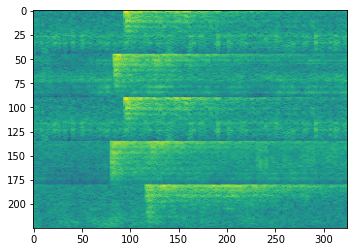

In [132]:
plt.imshow(X_tst[FP_ind[0],:,:,0])

### Explore Test-Set Positives:

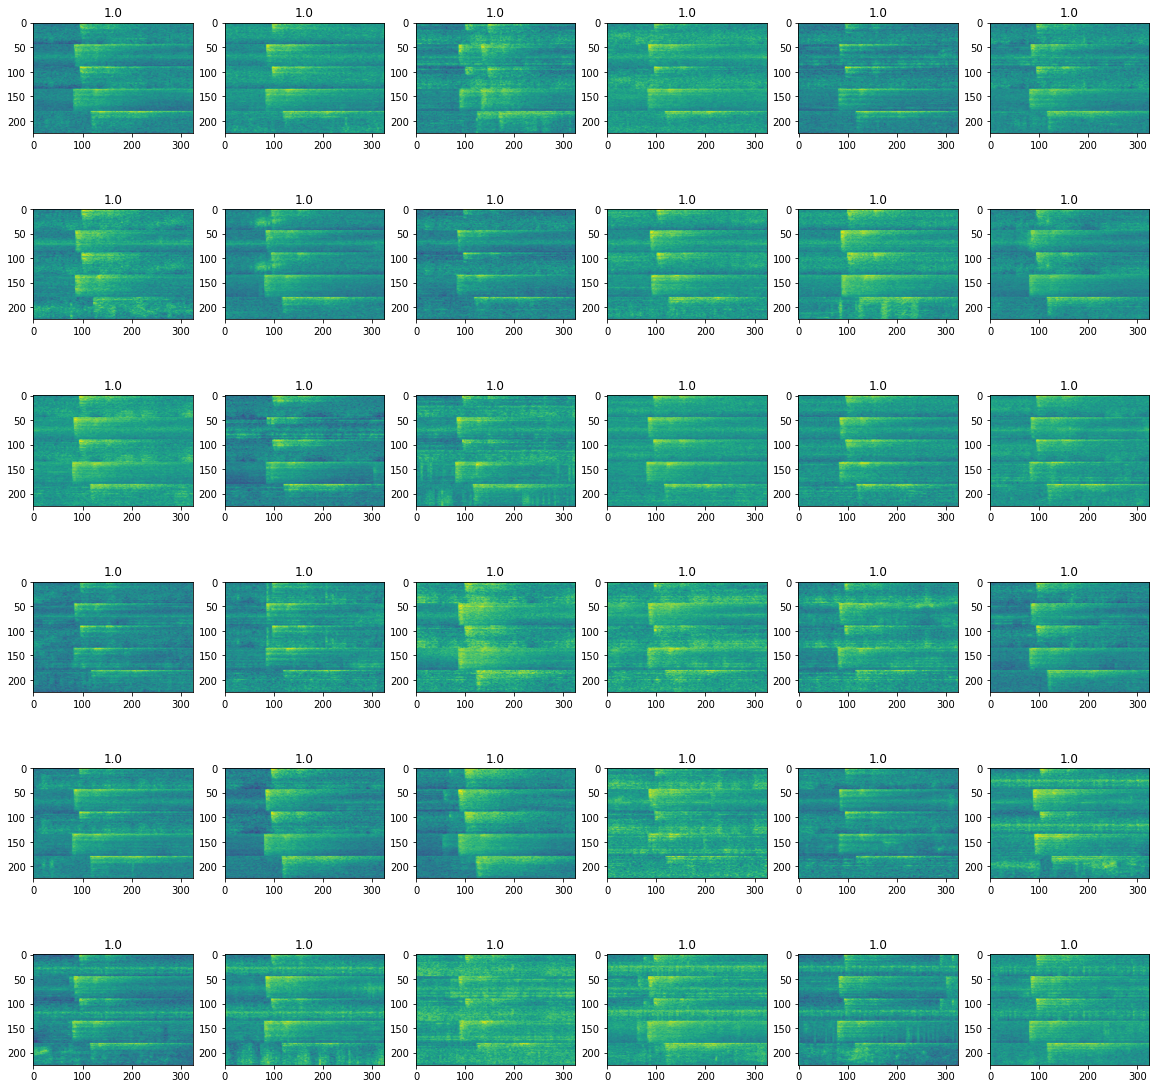

In [133]:
fig, ax = plt.subplots(6, 6, figsize=(20,20))

for i in range(6):
    for j in range(6):
        ax[i, j].imshow(X_tst[6*i+j,:,:,0])
        ax[i, j].set_title(Y_tst[6*i+j])

### Explore Test-Set Negatives:

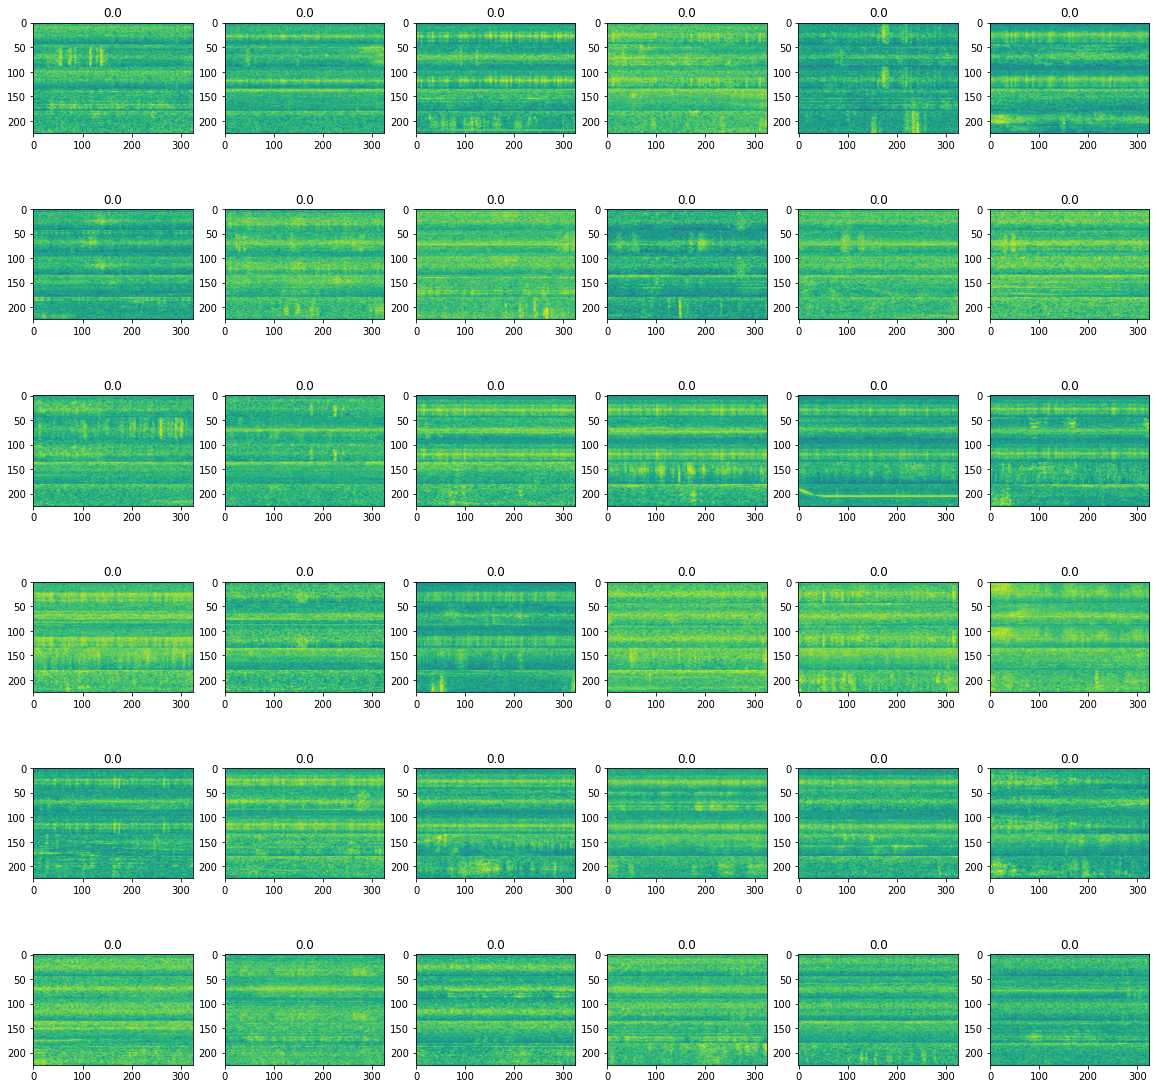

In [135]:
fig, ax = plt.subplots(6, 6, figsize=(20,20))

for i in range(6):
    for j in range(6):
        ax[i, j].imshow(X_tst[-(6*i+j+1),:,:,0])
        ax[i, j].set_title(Y_tst[-(6*i+j+1)])